# # Modelagem 1-dim 64 MFCCs

In [110]:
import keras as K
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from random import choice

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DIR_DATAFRAMES = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/DATAFRAMES'
DIR_MFCC = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC'

In [4]:
!ls -lah $DIR_DATAFRAMES

total 4,1G
drwxrwxrwx 1 hbrandao hbrandao 4,0K mar 21 23:15 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 21 23:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 181K mar 21 23:27 Xfusao.csv
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 372M mar 23 00:32 Xsinal.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_stretch_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_tile_0padded.npy


In [5]:
!ls -lahR $DIR_MFCC

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC:
total 0
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:49 .
drwxrwxrwx 1 hbrandao hbrandao 0 mar 21 23:49 ..
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:55 128
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:54 64
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:53 mean

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/128:
total 944M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:55 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_pad_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_stretch_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:11 Xsinal_tile_128mfcc.npy

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/64:
total 472M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:54 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 158M mar 22 02:05 Xsinal_pad_64mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 158M 

In [6]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
if PHYS_DEVICE_NAME:
    print(PHYS_DEVICE_NAME)
else:
    raise Exception('GPU não encontrada')

GPU:0


2023-03-27 21:30:56.242760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 21:30:56.261334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 21:30:56.261471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dados
___

In [7]:
X64 = np.load(f'{DIR_MFCC}/mean/Xsinal_64mfcc_mean.npy')

x64train, x64test, *_ = train_test_split(X64)
x64train.shape, x64test.shape

((1023, 64), (341, 64))

## Autoencoder
___

In [8]:
dim = X64.shape[-1]

In [9]:
def autoencoder64():
    inp_enc = K.Input(batch_shape=(1,dim))
    enc = layers.Dense(units=int(dim/2), activation='relu')(inp_enc)
    encoder = K.Model(inp_enc, enc)

    inp_dec = K.Input(batch_shape=(1,int(dim/2)))
    dec = layers.Dense(units=dim, activation='linear')(inp_dec)
    decoder = K.Model(inp_dec, dec)

    inp_ae = K.Input(batch_shape=(1,dim))
    enc_ae = encoder(inp_ae)
    dec_ae = decoder(enc_ae)

    ae = K.Model(inp_ae, dec_ae, name='autoencoder')
    ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return ae, encoder, decoder

### x64 train

In [13]:
epochs = 1000

es = EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=20, verbose=1)

mc = ModelCheckpoint('autoencoder_mean_64mfcc.hdf5',
                     monitor='loss', verbose=1, save_best_only=True, mode='min')

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    modelo64, encoder64, decoder64 = autoencoder64()
    history = modelo64.fit(x=x64train,
                           y=x64train,
                           epochs=epochs,
                           batch_size=10,
                           shuffle=True,
                           validation_data=(x64test, x64test),
                           callbacks=[es, mc])

2023-03-27 21:31:16.306758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 21:31:16.307394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 21:31:16.307545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 21:31:16.307653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/1000
103/103 [==============================] - 1s 2ms/step - loss: 2083.1621 - mae: 16.7346 - val_loss: 775.7332 - val_mae: 10.5134

Epoch 00001: loss improved from inf to 2083.16211, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 2/1000
  1/103 [..............................] - ETA: 0s - loss: 861.0836 - mae: 10.2687

2023-03-27 21:31:17.416931: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 0s 1ms/step - loss: 319.5668 - mae: 8.3858 - val_loss: 118.5673 - val_mae: 6.8733

Epoch 00002: loss improved from 2083.16211 to 319.56680, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 3/1000
103/103 [==============================] - 0s 1ms/step - loss: 105.1185 - mae: 6.6211 - val_loss: 93.7022 - val_mae: 6.2207

Epoch 00003: loss improved from 319.56680 to 105.11854, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 85.0967 - mae: 6.0415 - val_loss: 76.2667 - val_mae: 5.7363

Epoch 00004: loss improved from 105.11854 to 85.09670, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 5/1000
103/103 [==============================] - 0s 1ms/step - loss: 71.3388 - mae: 5.6298 - val_loss: 63.9981 - val_mae: 5.3581

Epoch 00005: loss improved from 85.09670 to 71.33877, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 6/1000
103/103 [==============================] - 0s 1

103/103 [==============================] - 0s 1ms/step - loss: 10.7321 - mae: 2.3809 - val_loss: 10.9087 - val_mae: 2.3977

Epoch 00037: loss improved from 11.06359 to 10.73209, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 38/1000
103/103 [==============================] - 0s 1ms/step - loss: 10.2977 - mae: 2.3223 - val_loss: 10.4465 - val_mae: 2.3522

Epoch 00038: loss improved from 10.73209 to 10.29766, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 39/1000
103/103 [==============================] - 0s 1ms/step - loss: 10.0260 - mae: 2.2898 - val_loss: 9.9361 - val_mae: 2.2825

Epoch 00039: loss improved from 10.29766 to 10.02603, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 40/1000
103/103 [==============================] - 0s 1ms/step - loss: 9.6781 - mae: 2.2539 - val_loss: 10.1518 - val_mae: 2.3176

Epoch 00040: loss improved from 10.02603 to 9.67808, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 41/1000
103/103 [==============================] - 0s 1ms/step 

Epoch 74/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2620 - mae: 1.9237 - val_loss: 7.3849 - val_mae: 1.9507

Epoch 00074: loss improved from 7.32836 to 7.26198, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 75/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2786 - mae: 1.9332 - val_loss: 7.5120 - val_mae: 1.9657

Epoch 00075: loss did not improve from 7.26198
Epoch 76/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2609 - mae: 1.9284 - val_loss: 7.4775 - val_mae: 1.9526

Epoch 00076: loss improved from 7.26198 to 7.26094, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 77/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2314 - mae: 1.9254 - val_loss: 7.3576 - val_mae: 1.9362

Epoch 00077: loss improved from 7.26094 to 7.23142, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 78/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.1555 - mae: 1.9141 - val_loss: 7.3853 -

103/103 [==============================] - 0s 1ms/step - loss: 6.5747 - mae: 1.8280 - val_loss: 6.9017 - val_mae: 1.9089

Epoch 00112: loss did not improve from 6.53563
Epoch 113/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5740 - mae: 1.8339 - val_loss: 6.7139 - val_mae: 1.8389

Epoch 00113: loss did not improve from 6.53563
Epoch 114/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5928 - mae: 1.8231 - val_loss: 6.7344 - val_mae: 1.8459

Epoch 00114: loss did not improve from 6.53563
Epoch 115/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5162 - mae: 1.8191 - val_loss: 6.6868 - val_mae: 1.8329

Epoch 00115: loss improved from 6.53563 to 6.51623, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 116/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4962 - mae: 1.8171 - val_loss: 6.7982 - val_mae: 1.8565

Epoch 00116: loss improved from 6.51623 to 6.49619, saving model to autoencoder_mean_64mfcc.

103/103 [==============================] - 0s 1ms/step - loss: 6.3342 - mae: 1.7874 - val_loss: 6.6450 - val_mae: 1.8409

Epoch 00153: loss did not improve from 6.28519
Epoch 154/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3541 - mae: 1.7904 - val_loss: 6.5657 - val_mae: 1.8128

Epoch 00154: loss did not improve from 6.28519
Epoch 155/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3249 - mae: 1.7849 - val_loss: 6.8572 - val_mae: 1.8607

Epoch 00155: loss did not improve from 6.28519
Epoch 156/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3297 - mae: 1.7884 - val_loss: 6.6229 - val_mae: 1.8389

Epoch 00156: loss did not improve from 6.28519
Epoch 157/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3626 - mae: 1.8086 - val_loss: 6.7929 - val_mae: 1.8585

Epoch 00157: loss did not improve from 6.28519
Epoch 158/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.3448 - mae: 1.7

103/103 [==============================] - 0s 1ms/step - loss: 6.2675 - mae: 1.7856 - val_loss: 6.8512 - val_mae: 1.8552

Epoch 00196: loss did not improve from 6.17933
Epoch 197/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2728 - mae: 1.7801 - val_loss: 6.8192 - val_mae: 1.8586

Epoch 00197: loss did not improve from 6.17933
Epoch 198/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2239 - mae: 1.7670 - val_loss: 6.5818 - val_mae: 1.8271

Epoch 00198: loss did not improve from 6.17933
Epoch 199/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.1938 - mae: 1.7650 - val_loss: 6.5264 - val_mae: 1.8204

Epoch 00199: loss did not improve from 6.17933
Epoch 200/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2360 - mae: 1.7798 - val_loss: 6.4416 - val_mae: 1.8042

Epoch 00200: loss did not improve from 6.17933
Epoch 201/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2137 - mae: 1.7

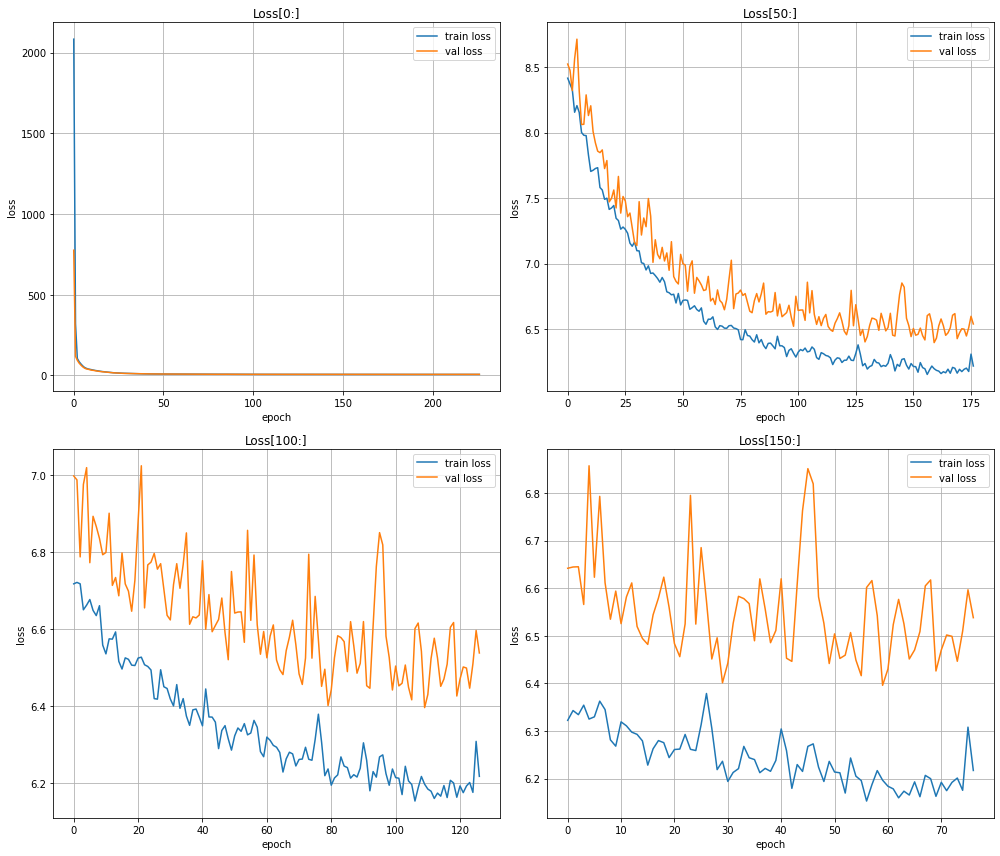

In [14]:
plt.figure(figsize=(14, 12))

row, col = 2, 2

for i,r in enumerate((0, 50, 100, 150)):
    plt.subplot(row,col,i+1)
    plt.plot(history.history['loss'][r:])
    plt.plot(history.history['val_loss'][r:])
    plt.title(f'Loss[{r}:]')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

plt.tight_layout()
plt.show()

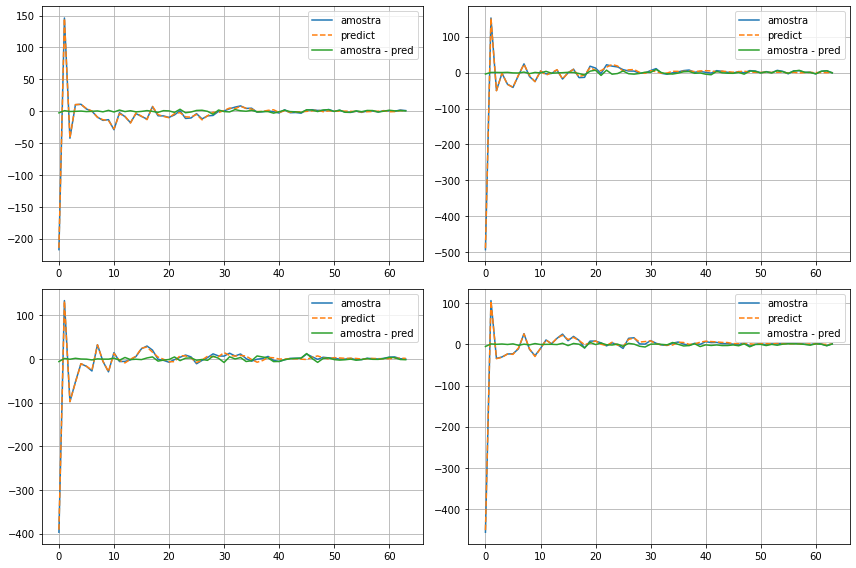

In [16]:
plt.figure(figsize=(12,8))

row, col, idx = 2, 2, 1

for i in range(row*col):
    reg = choice(x64train).reshape(1,dim)
    pred = modelo64.predict(reg)
    diff = reg - pred

    plt.subplot(row, col, idx)
    plt.plot(reg.flatten(), label='amostra')
    plt.plot(pred.flatten(), label='predict', linestyle='--')
    plt.plot(diff.flatten(), label='amostra - pred')
    plt.legend()
    plt.grid()
    idx += 1

plt.tight_layout()
plt.show()

In [17]:
pred_x64 = modelo64.predict(x64test)
loss_x64 = K.losses.mse(pred_x64, x64test)

np.mean(loss_x64)

6.5379634

### x64 train MinMax scaled

In [18]:
# x64scaled = MinMaxScaler().fit_transform(X64)
# x64train_scaled, x64test_scaled, *_ = train_test_split(X64)

# x64train_scaled.shape, x64test_scaled.shape

In [19]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     modelo64_scaled, *_ = autoencoder64()
#     history = modelo64_scaled.fit(x=x64train_scaled,
#                                   y=x64train_scaled,
#                                   epochs=epochs,
#                                   batch_size=10,
#                                   shuffle=True,
#                                   validation_data=(x64test_scaled, x64test_scaled),
#                                   callbacks=[es])

In [20]:
# plt.figure(figsize=(14, 12))

# row, col = 2, 2

# for i,r in enumerate((0, 50, 100, 150)):
#     plt.subplot(row,col,i+1)
#     plt.plot(history.history['loss'][r:])
#     plt.plot(history.history['val_loss'][r:])
#     plt.title(f'Loss[{r}:]')
#     plt.legend(['train loss', 'val loss'], loc='upper right')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.grid()

# plt.tight_layout()
# plt.show()

In [21]:
# plt.figure(figsize=(12,8))

# row, col, idx = 2, 2, 1

# for i in range(row*col):
#     reg = choice(x64train_scaled).reshape(1,dim)
#     pred = modelo64_scaled.predict(reg)
#     diff = reg - pred

#     plt.subplot(row, col, idx)
#     plt.plot(reg.flatten(), label='amostra_scaled')
#     plt.plot(pred.flatten(), label='predict_scaled', linestyle='--')
#     plt.plot(diff.flatten(), label='amostra_scaled - pred_scaled')
#     plt.legend()
#     plt.grid()
#     idx += 1

# plt.tight_layout()
# plt.show()

In [22]:
# pred_x64_scaled = modelo64_scaled.predict(x64test_scaled)
# loss_x64_scaled = K.losses.mse(pred_x64_scaled, x64test_scaled)

# np.mean(loss_x64_scaled)

#### Tentando um Autoencoder mais profundo

In [23]:
# def deep_autoencoder64():
#     K.backend.clear_session()

#     input64 = K.Input(batch_shape=(1,dim))

#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(input64)
#     encoder64 = layers.Dropout(0.25)(encoder64)
#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(encoder64)

#     decoder64 = layers.Dropout(0.25)(encoder64)
#     decoder64 = layers.Dense(units=int(dim/2), activation='relu')(decoder64)
#     decoder64 = layers.Dropout(0.25)(decoder64)
#     decoder64 = layers.Dense(units=dim, activation='linear')(decoder64)

#     ae64 = K.Model(input64, decoder64, name='deep_autoencoder64')
#     ae64.compile(optimizer='adam', loss='mse', metrics=['mae'])

#     print(ae64.summary())

#     return ae64

# deep_autoencoder64()

In [24]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     deep_modelo64 = deep_autoencoder64()
#     history = deep_modelo64.fit(x=x64train,
#                                 y=x64train,
#                                 epochs=epochs,
#                                 batch_size=10,
#                                 shuffle=True,
#                                 validation_data=(x64test, x64test),
#                                 callbacks=[es],
#                                )

In [25]:
# np.mean(
#     K.losses.mse(deep_modelo64.predict(x64test), x64test)
# )

Dados os experimentos, podemos assumir que o Autoencoder (`modelo64`) com dados não normalizados apresenta a melhor performance

In [26]:
# del x64train, x64test
# del x64scaled, x64train_scaled, x64test_scaled
# del modelo64_scaled, deep_modelo64

## Classificador

In [27]:
X64.shape

(1364, 64)

In [28]:
Xfusao = pd.read_csv(f'{DIR_DATAFRAMES}/Xfusao.csv', delimiter=';')
Xfusao.shape

(1364, 8)

In [29]:
Xfusao.head()

,path,dataset,arquivo,pessoa,genero,emocao,intensidade,duracao
0,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l1.wav,f1,f,alegria,NaN,2.451610
1,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l2.wav,f1,f,alegria,NaN,3.916553
2,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l3.wav,f1,f,alegria,NaN,3.482993
3,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l4.wav,f1,f,alegria,NaN,3.684354
4,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l5.wav,f1,f,alegria,NaN,2.343061


In [30]:
DE_PARA_EMOCAO = {
    'alegria': np.array([1,0,0,0]),
    'medo': np.array([0,1,0,0]),
    'raiva': np.array([0,0,1,0]),
    'surpresa': np.array([0,0,0,1]),
}

DE_PARA_INTENSIDADE = {
    'fraca': np.array([1,0,0,0]),
    'moderada': np.array([0,1,0,0]),
    'forte': np.array([0,0,1,0]),
    'pico': np.array([0,0,0,1]),
}

def encoding_emocao(emocao: str):
    return DE_PARA_EMOCAO.get(emocao)

def encoding_intensidade(intensidade: str):
    return DE_PARA_INTENSIDADE.get(intensidade)

In [31]:
Xfusao['emo'] = Xfusao['emocao'].apply(encoding_emocao)
Xfusao['int'] = Xfusao['intensidade'].apply(encoding_intensidade)

In [32]:
Xfusao.drop(labels=['path', 'pessoa', 'genero', 'duracao', 'emocao', 'intensidade'],
            axis=1, inplace=True)

In [33]:
Xfusao.tail()

,dataset,arquivo,emo,int
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]"
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]"
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]"
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"


In [34]:
Xfusao = pd.concat(objs=[Xfusao, pd.DataFrame(X64)], axis=1)
Xfusao.tail()

,dataset,arquivo,emo,int,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]",-429.589874,133.411682,-50.135876,-2.183036,-23.552435,16.127447,...,-0.139971,2.148980,0.202220,3.275567,-0.529448,-0.181059,4.731008,0.363102,0.874546,2.543077
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]",-464.718903,134.753693,-7.355528,23.141539,-41.095829,-12.439143,...,3.822853,2.926050,-2.851189,3.309691,0.376164,-0.513694,1.384362,2.246764,0.847502,-1.558109
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]",-335.451172,-14.470435,-37.541733,-11.240404,-18.821291,18.479385,...,0.819087,-0.181811,1.292265,-1.130435,5.381464,-1.318466,-2.149301,3.814080,-0.214485,2.099050
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-282.711945,70.662437,-39.934624,-4.440723,-53.481644,-15.649154,...,1.302397,-0.589643,-0.325025,5.137481,2.956725,-3.193030,-2.849084,5.133433,3.861740,0.229049
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-399.486450,103.588158,-58.144569,-14.114857,-41.650688,10.208106,...,1.302480,1.885603,-0.327338,-0.116328,2.800063,3.395798,-0.581741,1.221288,1.824211,2.366567


In [35]:
Xfusao_verbo = Xfusao[Xfusao['dataset'] == 'verbo']
Xfusao_verbo.shape

(666, 68)

In [36]:
Xfusao_vivae = Xfusao[Xfusao['dataset'] == 'vivae']
Xfusao_vivae.shape

(698, 68)

In [69]:
def realizar_encoding(x, dim=dim):
    return encoder64(x.reshape(1,dim).astype('float32'))

In [75]:
x64_vivae_enc = np.array([realizar_encoding(x) for x in Xfusao_vivae.values[:,4:]])
x64_vivae_enc.shape

(698, 1, 32)

In [89]:
y64_vivae = np.array([x.reshape(1,4) for x in Xfusao_vivae['int'].values])
y64_vivae.shape

(698, 1, 4)

In [90]:
xtrain, xtest, ytrain, ytest = train_test_split(x64_vivae_enc, y64_vivae)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((523, 1, 32), (523, 1, 4), (175, 1, 32), (175, 1, 4))

### Modelo

In [181]:
def modelo_clf_intensidade():
    K.backend.clear_session()
    modelo = K.Sequential()
    modelo.add(layers.Dense(units=32, activation='relu', input_shape=(1,32)))
    modelo.add(layers.Dense(units=16, activation='relu'))
    modelo.add(layers.Dense(units=8, activation='relu'))
    modelo.add(layers.Dense(units=4, activation='softmax'))

    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(modelo.summary())
    return modelo

modelo_clf_intensidade()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None


In [182]:
epochs = 1000

es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=20, verbose=1)

mc = ModelCheckpoint('classificador_intensidade_64mfcc_encoded.hdf5',
                     monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    clf_intensidade = modelo_clf_intensidade()
    history = clf_intensidade.fit(x=xtrain,
                                  y=ytrain,
                                  epochs=epochs,
                                  batch_size=2,
                                  shuffle=True,
                                  validation_data=(xtest, ytest),
                                  callbacks=[es, mc]
                                 )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
262/262 [==============================] - 1s 3ms/step - loss: 2.3368 - accuracy: 0.3327 - val_loss: 1.3698 - val_accuracy: 0.2800

Epoch 00001: val_accuracy improved from -inf to 0.28000, saving model to classificador_intensidade_64m

262/262 [==============================] - 1s 2ms/step - loss: 0.9596 - accuracy: 0.5545 - val_loss: 1.0619 - val_accuracy: 0.5371

Epoch 00033: val_accuracy did not improve from 0.54286
Epoch 34/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.9418 - accuracy: 0.5545 - val_loss: 1.2198 - val_accuracy: 0.4286

Epoch 00034: val_accuracy did not improve from 0.54286
Epoch 35/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.9262 - accuracy: 0.5602 - val_loss: 1.3093 - val_accuracy: 0.5086

Epoch 00035: val_accuracy did not improve from 0.54286
Epoch 36/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.9418 - accuracy: 0.5373 - val_loss: 1.0106 - val_accuracy: 0.5143

Epoch 00036: val_accuracy did not improve from 0.54286
Epoch 37/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.9624 - accuracy: 0.5449 - val_loss: 1.0807 - val_accuracy: 0.4914

Epoch 00037: val_accuracy did not improve from 0.54286
Epoch 38/

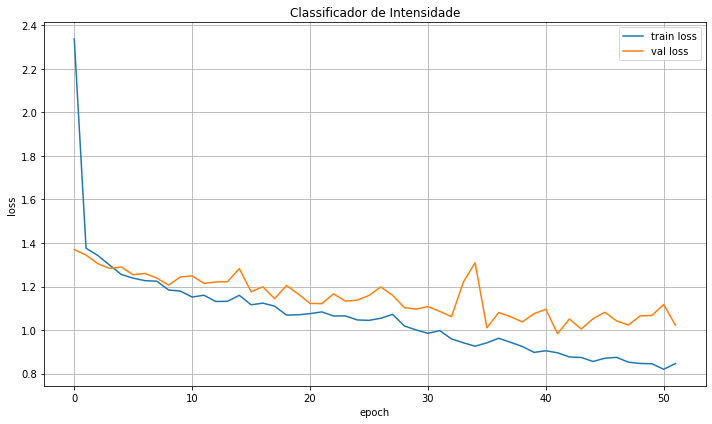

In [183]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.title('Classificador de Intensidade')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.tight_layout()
plt.show()

In [184]:
_ = classification_report(
    y_true=[np.argmax(x) for x in ytest],
    y_pred=[np.argmax(x) for x in clf_intensidade.predict(xtest)],
    target_names=DE_PARA_INTENSIDADE.keys()
)

print(_)

              precision    recall  f1-score   support

       fraca       0.62      0.80      0.70        40
    moderada       0.40      0.31      0.35        45
       forte       0.35      0.40      0.38        42
        pico       0.70      0.58      0.64        48

    accuracy                           0.52       175
   macro avg       0.52      0.52      0.51       175
weighted avg       0.52      0.52      0.51       175



#### VERBO

In [187]:
xtest_verbo = np.array([realizar_encoding(x) for x in Xfusao_verbo.values[:,4:]])
pred_verbo = [np.argmax(x) for x in clf_intensidade.predict(xtest_verbo)]

In [192]:
np.array(pred_verbo)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1,
       1, 1, 1, 0, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3,
       3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 3, 3, 2, 3, 3,
       3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2,
       2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2,
       2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3,

## Decomposição

In [ ]:
# pca, 4means, knn <- 4 classes

___
Refs:

- [62] https://sci-hub.se/10.1109/tmm.2017.2766843
- [63] https://sci-hub.se/10.1016/j.bspc.2018.08.035
- [64] https://arxiv.org/pdf/1712.08708.pdf
- [65] https://sci-hub.se/10.1109/icassp.2018.8462685
- [66] https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9136653
- [67] https://sci-hub.se/10.1109/ectidamtncon48261.2020.9090768
- [68] https://www.isca-speech.org/archive_v0/Interspeech_2019/pdfs/2561.pdf
- https://sci-hub.se/10.7717/peerj.488
